## MIDS UC Berkeley, Machine Learning at Scale 
 
__W261-1__ Summer 2016    
__Week 7__: SSSP    

__Name__   
name@ischool.berkeley.edu  

July 1, 2016   

***

### General Description

In this assignment you will explore networks and develop MRJob code for 
finding shortest path graph distances. To build up to large data 
you will develop your code on some very simple, toy networks.
After this you will take your developed code forward and modify it and 
apply it to two larger datasets (performing EDA along the way).

#### Undirected toy network dataset


In an undirected network all links are symmetric, 
i.e., for a pair of nodes 'A' and 'B,' both of the links:

A -> B and B -> A

will exist. 

The toy data are available in a sparse (stripes) representation:

(node) \t (dictionary of links)

on AWS/Dropbox via the url:

s3://ucb-mids-mls-networks/undirected_toy.txt
Or under the Data Subfolder for HW7 on Dropbox with the same file name. 
The Data folder is in: https://db.tt/Kxu48mL1)

In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).


#### Directed toy network dataset

In a directed network all links are not necessarily symmetric, 
i.e., for a pair of nodes 'A' and 'B,' it is possible for only one of:

A -> B or B -> A

to exist. 

These toy data are available in a sparse (stripes) representation:

(node) \t (dictionary of links)

on AWS/Dropbox via the url:

s3://ucb-mids-mls-networks/directed_toy.txt
Or under the Data Subfolder for HW7 on Dropbox with the same file name
(On Dropbox https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0)

In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).

### HW 7.0: Shortest path graph distances (toy networks)

In this part of your assignment you will develop the base of your code for the week.

Write MRJob classes to find shortest path graph distances, as described in the lectures. In addition to finding the distances, your code should also output a distance-minimizing path between the source and target.
Work locally for this part of the assignment, and use both of the undirected and directed toy networks.

To proof you code's function, run the following jobs

- shortest path in the undirected network from node 1 to node 4
Solution: 1,5,4. NOTE: There is another shortest path also (HINT: 1->5->4)! Either will suffice (you will find this also in the remaining problems. E.g., 7.2 and 7.4.
 

- shortest path in the directed network from node 1 to node 5
Solution: 1,2,4,5

and report your output---make sure it is correct!

#### Main dataset 1: NLTK synonyms

In the next part of this assignment you will explore a network derived from the NLTK synonym database used for evaluation in HW 5. At a high level, this network is undirected, defined so that there exists link between two nodes/words if the pair or words are a synonym. These data may be found at the location:

s3://ucb-mids-mls-networks/synNet/synNet.txt

s3://ucb-mids-mls-networks/synNet/indices.txt

On under the Data Subfolder for HW7 on Dropbox with the same file names

where synNet.txt contains a sparse representation of the network:

(index) \t (dictionary of links)

in indexed form, and indices.txt contains a lookup list

(word) \t (index)

of indices and words. This network is small enough for you to explore and run
scripts locally, but will also be good for a systems test (for later) on AWS.

In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).

##### ANSWER:

Below we have the code that returns the shortest path and its length for both the directed and undirected toy graph examples.


||Length of shortest path|Shortest path|
|---|---|---|
|__Undirected graph (1 to 4)__|2|1-5-4|
|__Directed graph (1 to 5)__|3|1->2->4->5|

Additionally, I wrote a mrjob that preprocesses the graph such that it may be traversed with the distributed SSSP algorithm. The resulting graph format is:

    node \t [comma_separated_out-edges, distance_from_source, node_state, path_from_source]

In [143]:
%%writefile adjacencyListToGraph.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
import sys
import os
import ast
from mrjob.protocol import RawValueProtocol
from mrjob.protocol import RawProtocol

class MRadjacencyListToGraph(MRJob):
    
    ## setting a default source node
    source_node = '7827'
    
    ## function permits us to pass an arbitrary source node
    ## to our mrjob
    def configure_options(self):
        super(MRadjacencyListToGraph, self).configure_options()
        self.add_passthrough_option('--source-node', type='int', default=10, help='...')
    
    def steps(self):
        return [MRStep(
                mapper_init=self.mapper_init,
                      mapper=self.mapper
                      )]
    ## setting the source node passed into the job
    def mapper_init(self):
        self.source_node = str(self.options.source_node)

    def mapper(self, _, line):
        line = line.strip()
        node, neighbors = line.split("\t")
        neighbors = ast.literal_eval(neighbors)
        neighbors_temp = ""
        ## process each neighbor to make neighbors array
        for k in neighbors.keys():
            if neighbors_temp == "":
                neighbors_temp = neighbors_temp + k
            else:
                neighbors_temp = neighbors_temp + "," + k
        if node == self.source_node:
            yield node, (neighbors_temp, 0, "Q",self.source_node)
        else:
            yield node, (neighbors_temp, sys.maxint, "U", "-")

if __name__ == "__main__":
    MRadjacencyListToGraph.run()

Overwriting adjacencyListToGraph.py


In [144]:
!chmod a+x adjacencyListToGraph.py

In [88]:
!./adjacencyListToGraph.py ~/w261/HW7/data/directed_toy/directed_toy.txt \
--source-node 1 > initial_directed_graph.txt
!cat initial_directed_graph.txt

Using configs in /home/cloudera/.mrjob.conf
Creating temp directory /tmp/adjacencyListToGraph.cloudera.20160710.161931.661966
Running step 1 of 1...
Streaming final output from /tmp/adjacencyListToGraph.cloudera.20160710.161931.661966/output...
Removing temp directory /tmp/adjacencyListToGraph.cloudera.20160710.161931.661966...
"4"	["2,5", 9223372036854775807, "U", "-"]
"5"	["1,2,4", 9223372036854775807, "U", "-"]
"1"	["2,6", 0, "Q", "1"]
"2"	["1,3,4", 9223372036854775807, "U", "-"]
"3"	["2,4", 9223372036854775807, "U", "-"]


In [89]:
!./adjacencyListToGraph.py /home/cloudera/w261/HW7/data/undirected_toy/undirected_toy.txt \
--source-node 1 > initial_undirected_graph.txt
!cat initial_undirected_graph.txt

Using configs in /home/cloudera/.mrjob.conf
Creating temp directory /tmp/adjacencyListToGraph.cloudera.20160710.161942.936205
Running step 1 of 1...
Streaming final output from /tmp/adjacencyListToGraph.cloudera.20160710.161942.936205/output...
Removing temp directory /tmp/adjacencyListToGraph.cloudera.20160710.161942.936205...
"4"	["3,2,5", 9223372036854775807, "U", "-"]
"5"	["1,2,4", 9223372036854775807, "U", "-"]
"1"	["2,5", 0, "Q", "1"]
"2"	["1,3,5,4", 9223372036854775807, "U", "-"]
"3"	["2,4", 9223372036854775807, "U", "-"]


In [90]:
%%writefile undirectedShortestPath.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
import sys
import os
import ast
from mrjob.protocol import RawValueProtocol
from mrjob.protocol import RawProtocol

class MRundirectedShortestPath(MRJob):
    
    def steps(self):
        return [MRStep(
                      mapper=self.mapper,
                      reducer=self.reducer
                      )]

    def mapper(self, _, line):
        line = line.strip()
        node, payload = line.split("\t")
        payload = ast.literal_eval(payload)
        neighbors = payload[0]
        distance = int(payload[1])
        state = payload[2]
        path = payload[3]
        neighbors_list = neighbors.split(",")
        ## If we are processing a node that is in
        ## the frontier for the current exploration
        ## step of the graph, we emit it as well as
        ## its neighbors
        if state == "Q":
            for n in neighbors_list:
                n_path = path + "-" + n
                ## We never want to emit "no neighbors"
                ## as a neighbor of the current node
                if n != "":
                    yield n, ("*", distance + 1, "Q", n_path)
            ## Again, if by some processing error we arrive at
            ## an "empty node", we do not want to emit it
            if str(node.strip('"')) != "":
                yield str(node.strip('"')), (neighbors, distance, "V", path)
        ## If the node being processed is not in the frontier
        ## we simply emit it unchanged
        elif state == "V" or state == "U":
            if str(node.strip('"')) != "":
                yield str(node.strip('"')), (neighbors, distance, state, path)
        else:
            ## As a safeguard against unexpected behavior we have this
            ## statement
            print "PROCESSING ERROR: UNEXPECTED STATE FOR NODE TO BE EMITTED BY MAPPER"

    def reducer(self, key, value):
        ## I am holding all the states for a single node (key)
        ## in this set
        state_set = set()
        ## The distances array holds the distance from the node (key)
        ## to all other nodes connecting to the node. This is used to
        ## calculate the minimum distance
        distances = []
        min_distance = 0
        max_neighbors = ""
        final_state = ""
        final_path = ""
        found_final_state = False
        if key != "":
            for v in value:
                neighbors, distance, state, path = v
                state_set.add(state)
                if path != "-":
                    ## given that these exercises are for unweighted
                    ## graphs, the moment a node is reached from the
                    ## source, it has by definition been reached
                    ## through the shortest path
                    final_path = path
                if neighbors != "*":
                    if max_neighbors == "":
                        max_neighbors = max_neighbors + neighbors
                    else:
                        ## This is accessed if we are processing a value
                        ## that is the result of an expanded nweighbor
                        ## in a mapper
                        max_neighbors = max_neighbors + "," + neighbors
                ## all distances are collected to later obtain
                ## the minimum distance
                distances.append(int(distance))
            if final_path == "":
                final_path = "-"
            if "V" in state_set:
                final_state = "V"
            elif "Q" in state_set:
                final_state = "Q"
            else:
                final_state = "U"
            min_distance = min(distances)
            yield key, (max_neighbors, min_distance, final_state, final_path)

if __name__ == "__main__":
    MRundirectedShortestPath.run()

Overwriting undirectedShortestPath.py


In [91]:
!chmod a+x undirectedShortestPath.py

In [93]:
%reload_ext autoreload
%autoreload 2

## preping the folders that will store the 
## inputs and outputs for the iterative
## graph exploration procedure
!rm -r toy_undirected_graph_input
!rm -r toy_undirected_graph_output
!mkdir toy_undirected_graph_input
!cp initial_undirected_graph.txt toy_undirected_graph_input/toy_undirected_graph_0.input

from undirectedShortestPath import MRundirectedShortestPath
from numpy import random,array
import ast

i = 0
while(1):
    frontier_exists = False
    j = i + 1
    mr_job = MRundirectedShortestPath(args=["toy_undirected_graph_input",
                                         "--output-dir", "toy_undirected_graph_output"])
    print "iteration "+str(i)+" of traversal ="
    graph = []
    with mr_job.make_runner() as runner: 
        runner.run()
        for line in runner.stream_output():
            node, payload = line.split("\t")
            node = node.strip('"')
            payload_raw = payload
            payload = ast.literal_eval(payload)
            state = payload[2]
            ## for this toy example, we can simply exit
            ## once there are no more nodes in the 
            ## frontier
            if state == "Q":
                frontier_exists = True
    i = i + 1
    ## cleaning folders to continue iterating
    ## through algorithm
    !rm -r toy_undirected_graph_input
    !cp -rT toy_undirected_graph_output toy_undirected_graph_input
    if not frontier_exists:
        break
print "Final graph state:"
!cat toy_undirected_graph_output/*

iteration 0 of traversal =
iteration 1 of traversal =
iteration 2 of traversal =
Final graph state:
"1"	["2,5", 0, "V", "1"]
"2"	["1,3,5,4", 1, "V", "1-2"]
"3"	["2,4", 2, "V", "1-2-3"]
"4"	["3,2,5", 2, "V", "1-5-4"]
"5"	["1,2,4", 1, "V", "1-5"]


In [94]:
%%writefile directedShortestPath.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
import sys
import os
import ast
from mrjob.protocol import RawValueProtocol
from mrjob.protocol import RawProtocol

class MRdirectedShortestPath(MRJob):
    
    def steps(self):
        return [MRStep(
                      mapper=self.mapper,
                      reducer=self.reducer
                      )]

    def mapper(self, _, line):
        line = line.strip()
        node, payload = line.split("\t")
        payload = ast.literal_eval(payload)
        neighbors = payload[0]
        distance = int(payload[1])
        state = payload[2]
        path = payload[3]
        neighbors_list = neighbors.split(",")
        ## If we are processing a node that is in
        ## the frontier for the current exploration
        ## step of the graph, we emit it as well as
        ## its neighbors
        if state == "Q":
            for n in neighbors_list:
                ## We never want to emit "no neighbors"
                ## as a neighbor of the current node
                n_path = path + "->" + n
                if n != "":
                    yield n, ("*", distance + 1, "Q", n_path)
                if n == "":
                    sys.stderr.write("This is an empty node\n")
            ## Again, if by some processing error we arrive at
            ## an "empty node", we do not want to emit it
            if str(node.strip('"')) != "":
                yield str(node.strip('"')), (neighbors, distance, "V", path)
        ## If the node being processed is not in the frontier
        ## we simply emit it
        elif state == "V" or state == "U":
            if str(node.strip('"')) != "":
                yield str(node.strip('"')), (neighbors, distance, state, path)
        else:
            ## As a safeguard against unexpected behavior we have this
            ## statement
            print "PROCESSING ERROR: UNEXPECTED STATE FOR NODE TO BE EMITTED BY MAPPER"

    def reducer(self, key, value):
        ## I am holding all the states for a single node (key)
        ## in this set
        state_set = set()
        ## The distances array holds the distance from the node (key)
        ## to all other nodes connecting TO the node. This is used to
        ## calculate the minimum distance
        distances = []
        min_distance = 0
        max_neighbors = ""
        final_state = ""
        final_path = ""
        found_final_state = False
        if key != "":
            for v in value:
                neighbors, distance, state, path = v
                state_set.add(state)
                if path != "-":
                    ## given that these exercises are for unweighted
                    ## graphs, the moment a node is reached from the
                    ## source, it has by definition been reached
                    ## through the shortest path
                    final_path = path
                if neighbors != "*":
                    if max_neighbors == "":
                        max_neighbors = max_neighbors + neighbors
                    else:
                        max_neighbors = max_neighbors + "," + neighbors
                distances.append(int(distance))
            if final_path == "":
                final_path = "-"
            if "V" in state_set:
                final_state = "V"
            elif "Q" in state_set:
                final_state = "Q"
            else:
                final_state = "U"
            min_distance = min(distances)
            yield key, (max_neighbors, min_distance, final_state, final_path)

if __name__ == "__main__":
    MRdirectedShortestPath.run()

Overwriting directedShortestPath.py


In [95]:
%reload_ext autoreload
%autoreload 2

!rm -r toy_directed_graph_input
!rm -r toy_directed_graph_output
!mkdir toy_directed_graph_input
!cp initial_directed_graph.txt toy_directed_graph_input/automated_graph_step_0.input

from directedShortestPath import MRdirectedShortestPath
from numpy import random,array
import ast

i = 0
while(1):
    frontier_exists = False
    j = i + 1
    mr_job = MRdirectedShortestPath(args=["toy_directed_graph_input",
                                         "--output-dir", "toy_directed_graph_output"])
    print "iteration "+str(i)+" of traversal ="
    graph = []
    with mr_job.make_runner() as runner: 
        runner.run()
        for line in runner.stream_output():
            node, payload = line.split("\t")
            node = node.strip('"')
            payload_raw = payload
            payload = ast.literal_eval(payload)
            state = payload[2]
            if state == "Q":
                frontier_exists = True
    i = i + 1

    !rm -r toy_directed_graph_input
    !cp -rT toy_directed_graph_output toy_directed_graph_input
    if not frontier_exists:
        break
!cat toy_directed_graph_output/*

iteration 0 of traversal =
iteration 1 of traversal =


This is an empty node


iteration 2 of traversal =
iteration 3 of traversal =
"1"	["2,6", 0, "V", "1"]
"2"	["1,3,4", 1, "V", "1->2"]
"3"	["2,4", 2, "V", "1->2->3"]
"4"	["2,5", 2, "V", "1->2->4"]
"5"	["1,2,4", 3, "V", "1->2->4->5"]
"6"	["", 1, "V", "1->6"]


### HW 7.1: Exploratory data analysis (NLTK synonyms)

Using MRJob, explore the synonyms network data.
Consider plotting the degree distribution (does it follow a power law?),
and determine some of the key features, like:

number of nodes, 
number links,
or the average degree (i.e., the average number of links per node),
etc...

As you develop your code, please be sure to run it locally first (though on the whole dataset). 
Once you have gotten you code to run locally, deploy it on AWS as a systems test
in preparation for our next dataset (which will require AWS).

##### ANSWER:

Plotting the number of degrees of the nodes in the network we can clearly see that the distribution of degrees follows a power law; that is, the histogram shows an exponential decay that visually approximates $f(d)=b^{g(d)}$ where d is degrees and g is a function that evaluates to a negative number.

Exploratory data analysis revealed that the __number of nodes in the synonyms graph is 8271, the average degree of nodes in the graph is 7.39, and the total number of links (edges) is 30567.__

Following the recommendation in the instructions, I first ran the code locally and then verified the same behavior in the AWS EMR ecosystem. The EMR specifications were as follows:

|Number of nodes|Node type|Runtime|
|---|---|---|
|6|m3.xlarge|95 seconds|

In [119]:
%%writefile synonyms_eda_plot.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
import sys
import os
import ast
from mrjob.protocol import RawValueProtocol
from mrjob.protocol import RawProtocol

class MR_synonyms_eda_plot(MRJob):
    
    def steps(self):
        return [MRStep(
            mapper=self.mapper)]
    
    ## only using a mapper as I simply want to transform
    ## the input data to do EDA
    def mapper(self, _, line):
        line = line.strip()
        node, payload = line.split("\t")
        payload = ast.literal_eval(payload)
        neighbors = payload[0]
        distance = int(payload[1])
        state = payload[2]
        path = payload[3]
        neighbors_list = neighbors.split(",")
        degrees = len(neighbors_list)
        yield node, degrees
        
if __name__ == "__main__":
    MR_synonyms_eda_plot.run()

Overwriting synonyms_eda_plot.py


In [120]:
!chmod a+x synonyms_eda_plot.py

In [121]:
!./synonyms_eda_plot.py synonyms_input/synonyms_input_0.input > synonyms_input_plot.txt
# !head synonyms_input_plot.txt

Using configs in /home/cloudera/.mrjob.conf
Creating temp directory /tmp/synonyms_eda_plot.cloudera.20160710.170605.976378
Running step 1 of 1...
Streaming final output from /tmp/synonyms_eda_plot.cloudera.20160710.170605.976378/output...
Removing temp directory /tmp/synonyms_eda_plot.cloudera.20160710.170605.976378...


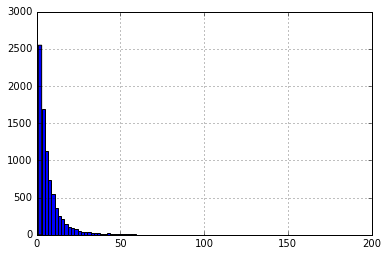

In [122]:
%matplotlib inline
import pandas as pd


df = pd.read_csv("synonyms_input_plot.txt",
                 sep='\t',
                header=None)

counts = pd.Series(df[1])
# print counts
counts.hist(bins=100)

In [123]:
%%writefile synonyms_eda.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
import sys
import os
import ast
from mrjob.protocol import RawValueProtocol
from mrjob.protocol import RawProtocol

class MR_synonyms_eda(MRJob):
    
    def steps(self):
        return [MRStep(
            mapper=self.mapper,
            combiner=self.combiner,
            reducer=self.reducer)]
        
    def mapper(self, _, line):
        line = line.strip()
        node, payload = line.split("\t")
        payload = ast.literal_eval(payload)
        neighbors = payload[0]
        distance = int(payload[1])
        state = payload[2]
        path = payload[3]
        neighbors_list = neighbors.split(",")
        degrees = len(neighbors_list)
        yield None, (1, degrees)
        
    def combiner(self, key, values):
        count, degrees = 0, 0
        for v in values:
            count += v[0]
            degrees += v[1]
        yield None, (count, degrees)
        
    def reducer(self, key, values):
        node_count, average_degrees, link_count = 0, 0, 0
        for v in values:
            node_count += v[0]
            link_count += v[1]
        average_degrees = float(link_count) / float(node_count)
        link_count = float(link_count) / 2.0
        yield None, (node_count, average_degrees, link_count)

if __name__ == "__main__":
    MR_synonyms_eda.run()

Overwriting synonyms_eda.py


In [124]:
!chmod a+x synonyms_eda.py

#### Local EDA run

In [138]:
# !./synonyms_eda.py synonyms_input/synonyms_input_0.input > synonyms_eda_local.output
!cat synonyms_eda_local.output

null	[8271, 7.391367428364164, 30567.0]


#### AWS synonym EDA run

In [135]:
## first we spool up a cluster
!mrjob create-cluster \
--max-hours-idle 1 \
--aws-region=us-west-2 -c ~/.mrjob.conf

In [134]:
!aws s3 rm s3://cerc-w261/HW7/synonyms_eda --recursive
!python /home/cloudera/w261/HW7/src/synonyms_eda.py \
-r emr s3://cerc-w261/HW7/synonyms_input \
    --cluster-id=j-TK4RCWUIOMPL \
    --aws-region=us-west-2 \
    --output-dir=s3://cerc-w261/HW7/synonyms_eda \
        --no-output

In [133]:
#!aws s3 cp s3://cerc-w261/HW7/synonyms_eda synonyns_eda_emr --recursive
!cat synonyns_eda_emr/*

null	[8271, 7.391367428364164, 30567.0]


### HW 7.2: Shortest path graph distances (NLTK synonyms)

Write (reuse your code from 7.0) an MRJob class to find shortest path graph distances, 
and apply it to the NLTK synonyms network dataset. 

Proof your code's function by running the job:

- shortest path starting at "walk" (index=7827) and ending at "make" (index=536),

and showing you code's output. Once again, your output should include the path and the distance.

As you develop your code, please be sure to run it locally first (though on the whole dataset). 
Once you have gotten you code to run locally, deploy it on AWS as a systems test
in preparation for our next dataset (which will require AWS).

=====================================

__NOTE: Dataset 2 English Wikipedia hyperlink network.data__

The dataset is available via Dropbox at:

https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0

on S3 at 

s3://ucb-mids-mls-networks/wikipedia/

s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt # Graph

s3://ucb-mids-mls-networks/wikipedia/indices.txt # Page titles and page Ids

For the remainder of this assignment you will explore the English Wikipedia hyperlink network.

The dataset is built from the Sept. 2015 XML snapshot of English Wikipedia.
For this directed network, a link between articles: 

A -> B

is defined by the existence of a hyperlink in A pointing to B.
This network also exists in the indexed format:

Data: s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt

Data: s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-in.txt

Data: s3://ucb-mids-mls-networks/wikipedia/indices.txt

but has an index with more detailed data:

(article name) \t (index) \t (in degree) \t (out degree)

In the dictionary, target nodes are keys, link weights are values.
Here, a weight indicates the number of time a page links to another.
However, for the sake of this assignment, treat this an unweighted network,
and set all weights to 1 upon data input.

##### ANSWER:

Reusing the code written for 7.0, I found that one of __the shortest path from node 7827 ("walk") to node 536 ("make") has a length of three and is as follows (local and AWS runs returned different, but valid shortest paths):__

    Local found: 7827-4655-631-536
    AWS found: 7827-1426-264-536

Following the recommendation in the instructions, I first ran the code locally and then verified the same behavior in the AWS EMR ecosystem. The EMR specifications were as follows:

|Job|Number of nodes|Node type|Runtime|
|---|---|---|---|
|__Adjacency List to SSSP input__|6|m3.xlarge|62 seconds|
|__SSP (node 7827 to 536)__|6|m3.xlarge|198 seconds|

#### Local implementation of synNet SSSP

In [147]:
%reload_ext autoreload
%autoreload 2

!rm -r synonyms_input
!rm -r synonyms_output
!mkdir synonyms_input
!./adjacencyListToGraph.py --source-node 7827 /home/cloudera/w261/HW7/data/synNet-synNet/synNet.txt \
> synonyms_input/synonyms_input_0.input

from undirectedShortestPath import MRundirectedShortestPath
from numpy import random,array
import ast

i = 0
while(1):
    frontier_exists = False
    j = i + 1
    mr_job = MRundirectedShortestPath(args=["synonyms_input",
                                         "--output-dir", "synonyms_output"])
    print "Processing iteration "+str(i)+" of algorithm"
    graph = []
    with mr_job.make_runner() as runner: 
        runner.run()
        for line in runner.stream_output():
            node, payload = line.split("\t")
            node = node.strip('"')
            payload_raw = payload
            payload = ast.literal_eval(payload)
            state = payload[2]
#             print line
            if state == "Q":
                frontier_exists = True
    i = i + 1
    !rm -r synonyms_input
    !cp -rT synonyms_output synonyms_input
    if not frontier_exists:
        break
print "Final graph state reached!"
#!cat automated_undirected_graph_step_output/*

Using configs in /home/cloudera/.mrjob.conf
Creating temp directory /tmp/adjacencyListToGraph.cloudera.20160710.180836.553287
Running step 1 of 1...
Streaming final output from /tmp/adjacencyListToGraph.cloudera.20160710.180836.553287/output...
Removing temp directory /tmp/adjacencyListToGraph.cloudera.20160710.180836.553287...
Processing iteration 0 of algorithm
Processing iteration 1 of algorithm
Processing iteration 2 of algorithm
Processing iteration 3 of algorithm
Processing iteration 4 of algorithm
Processing iteration 5 of algorithm
Processing iteration 6 of algorithm
Processing iteration 7 of algorithm
Processing iteration 8 of algorithm
Processing iteration 9 of algorithm
Processing iteration 10 of algorithm
Final graph state reached!


In [148]:
!cat synonyms_output/* |\
grep '"536"' | grep '536"]'

"536"	["215,3648,662,57,3658,3656,3657,3651,3652,3653,3555,3554,6002,3552,6000,6001,404,2248,2249,3750,2246,2247,3993,3992,3760,3761,1313,3481,3769,3483,3482,3485,121,265,264,3647,1554,5593,5592,5594,5596,3241,534,533,532,531,1668,2257,2256,2255,2254,5911,2252,2251,2250,3775,3774,4320,585,4651,4652,3471,3478,3621,448,3749,5353,3742,3743,3740,3741,3310,6003,1647,3551,2253,4420,4421,641,2794,5912,2160,3593,4318,3595,3594,3751,4180,3599,3598,64,69,657,653,659,631,3601,3600,4608,4609,3688,1801,722,6058,6057,6056,2439,1209,5210,1162,3738,1661,3739,5211,3737,1199,5354,1810,1811,5351,1195,770,4316,4317,5281,4319,3622,616,73,5209,5208,4791,5352,6004,5366,5364,5365,1681,1685,1477,474,1688,3553", 3, "V", "7827-4655-631-536"]


#### AWS implementation of synNet SSSP

The main difference between my AWS and local implementations is that I stopped by AWS algorithm as soon as I found the shortest path that I was looking for as opposed to continuing to compute the shortest path to all nodes.

In [55]:
## Upload raw materials to AWS
!aws s3 cp /home/cloudera/w261/HW7/data/synNet-synNet/synNet.txt \
s3://cerc-w261/HW7/synNet-synNet/

upload: ../data/synNet-synNet/synNet.txt to s3://cerc-w261/HW7/synNet-synNet/synNet.txt


In [68]:
!aws s3 rm s3://cerc-w261/HW7/synonyms_input --recursive
!python /home/cloudera/w261/HW7/src/adjacencyListToGraph.py --source-node 7827 \
-r emr s3://cerc-w261/HW7/synNet-synNet \
    --cluster-id=j-TK4RCWUIOMPL \
    --aws-region=us-west-2 \
    --output-dir=s3://cerc-w261/HW7/synonyms_input \
        --no-output

Using configs in /home/cloudera/.mrjob.conf
Unexpected option emr_cluster_id from /home/cloudera/.mrjob.conf
Unexpected option hadoop from /home/cloudera/.mrjob.conf
Using s3://mrjob-4b78edd1b5baad75/tmp/ as our temp dir on S3
Creating temp directory /tmp/adjacencyListToGraph.cloudera.20160710.020708.989896
Copying local files to s3://mrjob-4b78edd1b5baad75/tmp/adjacencyListToGraph.cloudera.20160710.020708.989896/files/...
Adding our job to existing cluster j-397C64HGINOL4
Waiting for step 1 of 1 (s-2S88IO7YV55NL) to complete...
  Opening ssh tunnel to resource manager...
  Connect to resource manager at: http://localhost:40302/cluster
  RUNNING for 17.2s
Unable to connect to resource manager
  RUNNING for 49.1s
  COMPLETED
Attempting to fetch counters from logs...
Looking for step log in /mnt/var/log/hadoop/steps/s-2S88IO7YV55NL on ec2-54-186-16-21.us-west-2.compute.amazonaws.com...
  Parsing step log: ssh://ec2-54-186-16-21.us-west-2.compute.amazonaws.com/mnt/var/log/hadoop/steps/s-2

In [150]:
%reload_ext autoreload
%autoreload 2


!aws s3 rm s3://cerc-w261/HW7/synonyms_input/ --recursive --quiet
!python /home/cloudera/w261/HW7/src/adjacencyListToGraph.py --source-node 7827 \
-r emr s3://cerc-w261/HW7/synNet-synNet \
    --cluster-id=j-TK4RCWUIOMPL \
    --aws-region=us-west-2 \
    --output-dir=s3://cerc-w261/HW7/synonyms_input \
        --no-output

!aws s3 rm s3://cerc-w261/HW7/synonyms_output --recursive --quiet

from undirectedShortestPath import MRundirectedShortestPath
from numpy import random,array
import ast

i = 0
while(1):
    frontier_exists = False
    path_found = False
    j = i + 1
    mr_job = MRundirectedShortestPath(args=["-r","emr",
                                            "s3://cerc-w261/HW7/synonyms_input",
                                            "--cluster-id=j-TK4RCWUIOMPL",
                                            "--aws-region=us-west-2",
                                         "--output-dir", "s3://cerc-w261/HW7/synonyms_output"])
    print "Progressing through iteration "+str(i)+" of the algorithm"
    graph = []
    with mr_job.make_runner() as runner: 
        runner.run()
        for line in runner.stream_output():
            node, payload = line.split("\t")
            node = node.strip('"')
            payload_raw = payload
            payload = ast.literal_eval(payload)
            state = payload[2]
            path = payload[3]
            if node == "536":
                print path
                if path != "-":
                    print "####################################################"
                    print "####################################################\n\n"
                    print "The above path is the shortest we were looking for!!"
                    print "\n\n####################################################"
                    print "####################################################"
                    path_found = True
                    break
#             print line
            if state == "Q":
                frontier_exists = True
            
    i = i + 1
#     !rm -r synonyms_input
#     !cp -rT synonyms_output synonyms_input
    !aws s3 rm s3://cerc-w261/HW7/synonyms_input/ --recursive --quiet
    !aws s3 cp s3://cerc-w261/HW7/synonyms_output s3://cerc-w261/HW7/synonyms_input/ --recursive --quiet
    !aws s3 rm s3://cerc-w261/HW7/synonyms_output/ --recursive --quiet
    if not frontier_exists or path_found:
        break
# print "Final graph state reached!"
#!cat automated_undirected_graph_step_output/*

Using configs in /home/cloudera/.mrjob.conf
Unexpected option emr_cluster_id from /home/cloudera/.mrjob.conf
Unexpected option hadoop from /home/cloudera/.mrjob.conf
Using s3://mrjob-4b78edd1b5baad75/tmp/ as our temp dir on S3
Creating temp directory /tmp/adjacencyListToGraph.cloudera.20160710.181403.263675
Copying local files to s3://mrjob-4b78edd1b5baad75/tmp/adjacencyListToGraph.cloudera.20160710.181403.263675/files/...
Adding our job to existing cluster j-TK4RCWUIOMPL
Waiting for step 1 of 1 (s-3SRZLUPP4DKWN) to complete...
  PENDING (cluster is WAITING: Cluster ready after last step completed.)
  Opening ssh tunnel to resource manager...
  Connect to resource manager at: http://localhost:40358/cluster
  RUNNING for 29.7s
     5.0% complete
  RUNNING for 62.7s
    90.5% complete
  COMPLETED
Attempting to fetch counters from logs...
Looking for step log in /mnt/var/log/hadoop/steps/s-3SRZLUPP4DKWN on ec2-54-187-170-182.us-west-2.compute.amazonaws.com...
  Parsing step log: ssh://ec2

### HW 7.3: Exploratory data analysis (Wikipedia)

Using MRJob, explore the Wikipedia network data on the AWS cloud. Reuse your code from HW 7.1---does is scale well? 

Be cautioned that Wikipedia is a directed network, where links are not symmetric. 
So, even though a node may be linked to, it will not appear as a primary record itself if it has no out-links. 

This means that you may have to ADJUST your code (depending on its design). 

To be sure of your code's functionality in this context, run a systems test on the directed_toy.txt network.

###### ANSWER:

To conduct the same exploratory data analysis from HW 7.1 on the wikipedia graph, given that it is a directed graph, I opted not to divide the sum of the out degrees by two as was needed for the synNet graph. 

As to the question of whether the code scales appropriately to the wikipedia graph, I believe that it does, given the relatively short time to execute for the job (~3 minutes), and the fact that I designed the job to use combiners (taking advantage of the commutative intermediate operations that would be performed by the reducers).

See below for the exploratory data analysis for the toy and wikipedia graphs:

| |Number of nodes|Average degrees|Number of edges|
|---|---|---|---|
|__Toy graph__|5|2.4|12|
|__Wikipedia graph__|5,781,290|24.58|142,114,057|

The EMR specifications for running the wikipedia job in the cloud were as follows:

|Number of nodes|Node type|Runtime|
|---|---|---|
|6|m3.xlarge|160 seconds|

In [5]:
%%writefile wiki_eda.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
import sys
import os
import ast
from mrjob.protocol import RawValueProtocol
from mrjob.protocol import RawProtocol

class MR_wiki_eda(MRJob):
    
    def steps(self):
        return [MRStep(
            mapper=self.mapper,
            combiner=self.combiner,
            reducer=self.reducer)]
        
    def mapper(self, _, line):
        line = line.strip()
        node, payload = line.split("\t")
        payload = ast.literal_eval(payload)
        degrees = len(payload)
        yield None, (1, degrees)
        
    def combiner(self, key, values):
        count, degrees = 0, 0
        for v in values:
            count += v[0]
            degrees += v[1]
        yield None, (count, degrees)
        
    def reducer(self, key, values):
        node_count, average_degrees, link_count = 0, 0, 0
        for v in values:
            node_count += v[0]
            link_count += v[1]
        average_degrees = float(link_count) / float(node_count)
        link_count = float(link_count)
        yield None, (node_count, average_degrees, link_count)

if __name__ == "__main__":
    MR_wiki_eda.run()

Overwriting wiki_eda.py


In [6]:
!chmod a+x wiki_eda.py

In [153]:
# !./adjacencyListToGraph.py /home/cloudera/w261/HW7/data/directed_toy/directed_toy.txt \
# > /home/cloudera/w261/HW7/data/directed_toy/initial_directed_graph.txt
# !cat /home/cloudera/w261/HW7/data/directed_toy/initial_directed_graph.txt
# !./wiki_eda.py /home/cloudera/w261/HW7/data/directed_toy/initial_directed_graph.txt > wiki_eda_local.output
!cat wiki_eda_local.output

null	[5, 4.0, 20.0]


In [151]:
!aws s3 sync s3://ucb-mids-mls-networks/wikipedia s3://cerc-w261/HW7/wiki/inputs --quiet

#### AWS implementation of wikipedia EDA

In [157]:
# !aws s3 sync s3://ucb-mids-mls-networks/wikipedia s3://cerc-w261/HW7/wiki/inputs
!aws s3 rm s3://cerc-w261/HW7/wiki/output_eda/ --recursive
!python /home/cloudera/w261/HW7/src/wiki_eda.py -r emr \
s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt \
    --cluster-id=j-TK4RCWUIOMPL \
    --aws-region=us-west-2 \
    --output-dir=s3://cerc-w261/HW7/wiki/output_eda \
        --no-output

Using configs in /home/cloudera/.mrjob.conf
Unexpected option emr_cluster_id from /home/cloudera/.mrjob.conf
Unexpected option hadoop from /home/cloudera/.mrjob.conf
Using s3://mrjob-4b78edd1b5baad75/tmp/ as our temp dir on S3
Could not infer endpoint for bucket ucb-mids-mls-networks; assuming s3.amazonaws.com
Creating temp directory /tmp/wiki_eda.cloudera.20160710.184020.659948
Copying local files to s3://mrjob-4b78edd1b5baad75/tmp/wiki_eda.cloudera.20160710.184020.659948/files/...
Adding our job to existing cluster j-TK4RCWUIOMPL
Waiting for step 1 of 1 (s-38TEYY9A7Y1P9) to complete...
  Opening ssh tunnel to resource manager...
  Connect to resource manager at: http://localhost:40358/cluster
  RUNNING for 5.0s
Unable to connect to resource manager
  RUNNING for 36.6s
  RUNNING for 67.7s
  RUNNING for 99.1s
  RUNNING for 129.6s
  RUNNING for 160.2s
  COMPLETED
Attempting to fetch counters from logs...
Looking for step log in /mnt/var/log/hadoop/steps/s-38TEYY9A7Y1P9 on ec2-54-187-170

In [158]:
!aws s3 cp s3://cerc-w261/HW7/wiki/output_eda wiki_eda_output --recursive --quiet
!cat wiki_eda_output/*

null	[5781290, 24.58172086160701, 142114057.0]


### HW 7.4: Shortest path graph distances (Wikipedia)

Using MRJob, find shortest path graph distances in the Wikipedia network on the AWS cloud.
Reuse your code from 7.2, but once again be warned of Wikipedia being a directed network.
To be sure of your code's functionality in this context, run a systems test on the directed_toy.txt network.

When running your code on the Wikipedia network, proof its function by running the job:

- shortest path from "Ireland" (index=6176135) to "University of California, Berkeley" (index=13466359),

and show your code's output. Show the shortest path in terms of just page IDS but also in terms of the name of page (show of your MapReduce join skills!!)

Once your code is running, find some other shortest paths and report your results.

##### ANSWER:

I found the __shortest path from node 6176135 to node 13466359 to be of length two:__

    6176135->11607791->13466359
    
The AWS components and runtimes were as follows:

|Job|Number of nodes|Node type|Runtime|
|---|---|---|---|
|__Adjacency List to SSSP input__|6|m3.xlarge|182 seconds|
|__SSP (node 6176135 to 13466359)__|6|m3.xlarge|274 seconds|

In [77]:
%%writefile adjacencyListToGraph_wiki.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
import sys
import os
import ast
from mrjob.protocol import RawValueProtocol
from mrjob.protocol import RawProtocol

class MRadjacencyListToGraph_wiki(MRJob):
    
    source_node = '6176135'
    
    def steps(self):
        return [MRStep(
                mapper_init=self.mapper_init,
                      mapper=self.mapper
                      )]
    #####################################
    #####################################
        
    def configure_options(self):
        super(MRadjacencyListToGraph_wiki, self).configure_options()
        self.add_passthrough_option('--source-node', type='int', default=1, help='...')
    
    def mapper_init(self):
        self.source_node = str(self.options.source_node)
            
    #####################################
    #####################################
    
    def mapper(self, _, line):
        line = line.strip()
        node, payload = line.split("\t")
        neighbors = ast.literal_eval(payload)
        neighbors_temp = ""
        for k in neighbors.keys():
            if neighbors_temp == "":
                neighbors_temp = neighbors_temp + k
            else:
                neighbors_temp = neighbors_temp + "," + k
        if node == self.source_node:
            yield node, (neighbors_temp, 0, "Q",self.source_node)
        else:
            yield node, (neighbors_temp, sys.maxint, "U", "-")
        
if __name__ == "__main__":
    MRadjacencyListToGraph_wiki.run()

Overwriting adjacencyListToGraph_wiki.py


In [78]:
!chmod a+x adjacencyListToGraph_wiki.py

In [79]:
!aws s3 rm s3://cerc-w261/HW7/wiki_path_input/ --recursive
# !aws s3 rm s3://cerc-w261/HW7/synonyms_input --recursive
!python /home/cloudera/w261/HW7/src/adjacencyListToGraph_wiki.py --source-node 6176135 \
-r emr s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt \
    --cluster-id=j-397C64HGINOL4 \
    --aws-region=us-west-2 \
    --output-dir=s3://cerc-w261/HW7/wiki_path_input \
        --no-output

Using configs in /home/cloudera/.mrjob.conf
Unexpected option emr_cluster_id from /home/cloudera/.mrjob.conf
Unexpected option hadoop from /home/cloudera/.mrjob.conf
Using s3://mrjob-4b78edd1b5baad75/tmp/ as our temp dir on S3
Could not infer endpoint for bucket ucb-mids-mls-networks; assuming s3.amazonaws.com
Creating temp directory /tmp/adjacencyListToGraph_wiki.cloudera.20160710.042656.049026
Copying local files to s3://mrjob-4b78edd1b5baad75/tmp/adjacencyListToGraph_wiki.cloudera.20160710.042656.049026/files/...
Adding our job to existing cluster j-397C64HGINOL4
Waiting for step 1 of 1 (s-3A33DQB1DB0YU) to complete...
  Opening ssh tunnel to resource manager...
  Connect to resource manager at: http://localhost:40302/cluster
  RUNNING for 24.8s
Unable to connect to resource manager
  RUNNING for 57.2s
  RUNNING for 88.5s
  RUNNING for 119.1s
  RUNNING for 150.0s
  RUNNING for 181.2s
  COMPLETED
Attempting to fetch counters from logs...
Looking for step log in /mnt/var/log/hadoop/st

In [ ]:
MRdirectedShortestPath

In [80]:
%reload_ext autoreload
%autoreload 2

!aws s3 rm s3://cerc-w261/HW7/wiki_path_output --recursive

from directedShortestPath import MRdirectedShortestPath
from numpy import random,array
import ast

i = 0
while(1):
    frontier_exists = False
    path_found = False
    j = i + 1
    mr_job = MRdirectedShortestPath(args=["-r","emr",
                                            "s3://cerc-w261/HW7/wiki_path_input",
                                            "--cluster-id=j-397C64HGINOL4",
                                            "--aws-region=us-west-2",
                                         "--output-dir", "s3://cerc-w261/HW7/wiki_path_output"])
    print "iteration "+str(i)+" of traversal ="
    graph = []
    with mr_job.make_runner() as runner: 
        runner.run()
        for line in runner.stream_output():
            node, payload = line.split("\t")
            node = node.strip('"')
            payload_raw = payload
            payload = ast.literal_eval(payload)
            state = payload[2]
            path = payload[3]
            if node == "13466359":
                print path
                if path != "-":
                    print "The above path is the shortest we were looking for!!"
                    path_found = True
                    break
#             print line
            if state == "Q":
                frontier_exists = True
            
    i = i + 1

    !aws s3 rm s3://cerc-w261/HW7/wiki_path_input/ --recursive
    !aws s3 cp s3://cerc-w261/HW7/wiki_path_output s3://cerc-w261/HW7/wiki_path_input/ --recursive
    !aws s3 rm s3://cerc-w261/HW7/wiki_path_output/ --recursive
    if not frontier_exists or path_found:
        break
print "Final graph state reached!"

iteration 0 of traversal =
-
delete: s3://cerc-w261/HW7/wiki_path_input/_SUCCESS
delete: s3://cerc-w261/HW7/wiki_path_input/part-00009
delete: s3://cerc-w261/HW7/wiki_path_input/part-00010
delete: s3://cerc-w261/HW7/wiki_path_input/part-00011
delete: s3://cerc-w261/HW7/wiki_path_input/part-00000
delete: s3://cerc-w261/HW7/wiki_path_input/part-00001
delete: s3://cerc-w261/HW7/wiki_path_input/part-00006
delete: s3://cerc-w261/HW7/wiki_path_input/part-00002
delete: s3://cerc-w261/HW7/wiki_path_input/part-00003
delete: s3://cerc-w261/HW7/wiki_path_input/part-00012
delete: s3://cerc-w261/HW7/wiki_path_input/part-00005
delete: s3://cerc-w261/HW7/wiki_path_input/part-00004
delete: s3://cerc-w261/HW7/wiki_path_input/part-00007
delete: s3://cerc-w261/HW7/wiki_path_input/part-00008
delete: s3://cerc-w261/HW7/wiki_path_input/part-00014
delete: s3://cerc-w261/HW7/wiki_path_input/part-00013
delete: s3://cerc-w261/HW7/wiki_path_input/part-00017
delete: s3://cerc-w261/HW7/wiki_path_input/part-00015
d

ValueError: I/O operation on closed file

### HW 7.5: Conceptual exercise: Largest single-source network distances

Suppose you wanted to find the largest network distance from a single source,
i.e., a node that is the furthest (but still reachable) from a single source.

How would you implement this task? 
How is this different from finding the shortest path graph distances?

Is this task more difficult to implement than the shortest path distance?

As you respond, please comment on program structure, runtimes, iterations, general system requirements, etc...

##### ANSWER:

Implementing the task of finding the node that is furthest (but still reachable) in a graph from a single source would be implemented in a fashion not too different from that which we used to find the shortest path from the source to all reachable nodes in the network; __since it is not specified in the question and we primarily dealt with unweighted graphs in this homework assignment I am providing an answer for the largest distance in an unweighted graph problem__.

To solve this problem I would iterate through the graph in a distributed BFS fashion similar to how it was exected in the distributed SSSP algorithm. Moving forward I will assume that if there are multiple paths from the source to a node in the network the path to be considered as a candidate for the "longest path distance" in the network is the shortest of the paths between the source and the node. With this assumption, we can proceed with the distributed breadth first search algorithm, having our iterating master process hold a global maximum distance to be compared against the distances found in the latest iteration of the algorithm.

That said, we can simplify this as the breadth first search of an unweighted graph, given the design of our MR algorithm, will always have in the boundary the known/discovered nodes that are the farthest from the source node. Hence if we sort in descending order the distances for the nodes in the boundary (hint, in the BFS unweighted case the distances for the frontier nodes will all be the same!) and output the top distance, once the algorithm terminates (there are no more nodes in the frontier), all we need do is see the latest of these top distances output!

To reiterate, given the above implementation, this algorithm is clearly not that different from SSSP. Moreover, this task would not be significantly more difficult to implement than SSSP.

In terms of __program structure__, it would be very similar to SSSP in that the algorithm would be iterative: a MRJob would be iteratively applied to the graph by a master process that would monitor progress for the stopping condition (i.e. there are no more nodes in the frontier).

In terms of __runtimes__, this algorithm would be $O(V+E)$ much like SSSP as we would need to explore all reachable nodes and edges to find the maximum distance.

In terms of __general system requirements__, these would not differ from those of SSP for a similarly sized graph.

### HW 7.5.1:

Can we utilize combiners in the HW 7 to perform the shortest path implementation?

Does order inversion help with the HW 7 shortest path implementation?

##### ANSWER:

Since the operations of finding the minimum distance

### HW 7.5.2: OPTIONAL

Implement combiners in the context of HW 7.5 and contrast the performance of this implementation versus the implementation with no combiners. 

Please report the cluster configuration and runtimes in tabular format for both experiments and comment on your findings.

##### ANSWER:



#### HW 7.6: Computational exercise: Largest single-source network distances: OPTIONAL

Using MRJob, write a code to find the largest graph distance and distance-maximizing nodes from a single-source.
Test your code first on the toy networks and synonyms network to proof its function.

==================END HW 7==================